# 책 추천 알고리즘
[데이터셋](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset)

## 0.라이브러리 불러오기

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from urllib import request
from urllib.request import Request, urlopen

from IPython.core.display import Image

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from category_encoders import OrdinalEncoder

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# pd.options.display.float_format = '{:.2f}'.format

## 1. 데이터 EDA

### 1-1. 데이터 불러오기

In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/project2/Book reviews/"

In [5]:
users = pd.read_csv(data_path + 'BX-Users.csv', sep=';', encoding='latin-1',low_memory=False)
books = pd.read_csv(data_path + 'BX_Books.csv', sep=';', encoding='latin-1',low_memory=False)
ratings = pd.read_csv(data_path + 'BX-Book-Ratings.csv', sep=';', encoding='latin-1',low_memory=False)

In [6]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [7]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
users.shape, books.shape, ratings.shape

((278858, 3), (271379, 8), (1149780, 3))

### 1-2 네 개의 데이터 셋을 하나로 합치기

users와 ratings을 User-ID를 기준으로 합치기

In [10]:
origin = pd.merge(users, ratings, on='User-ID', how='right')
origin.shape

(1149780, 5)

books와 위 두개를 합친 것을 ISBN을 기준으로 합치기

In [11]:
origin = pd.merge(origin, books, on='ISBN', how='left')
origin.shape

(1149780, 12)

### 1-3. 데이터 살펴보기

In [12]:
df = origin.copy()

In [13]:
df.head()

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,"tyler, texas, usa",NaN,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,"seattle, washington, usa",NaN,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,"h, new south wales, australia",16.0,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,"rijeka, n/a, croatia",16.0,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,"rijeka, n/a, croatia",16.0,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...


In [14]:
# 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1149780 non-null  int64  
 1   Location             1149780 non-null  object 
 2   Age                  840288 non-null   float64
 3   ISBN                 1149780 non-null  object 
 4   Book-Rating          1149780 non-null  int64  
 5   Book-Title           1031175 non-null  object 
 6   Book-Author          1031174 non-null  object 
 7   Year-Of-Publication  1031175 non-null  float64
 8   Publisher            1031173 non-null  object 
 9   Image-URL-S          1031175 non-null  object 
 10  Image-URL-M          1031175 non-null  object 
 11  Image-URL-L          1031175 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 114.0+ MB


In [15]:
# 결측치 확인
df.isnull().sum()

User-ID                     0
Location                    0
Age                    309492
ISBN                        0
Book-Rating                 0
Book-Title             118605
Book-Author            118606
Year-Of-Publication    118605
Publisher              118607
Image-URL-S            118605
Image-URL-M            118605
Image-URL-L            118605
dtype: int64

In [16]:
# Location
print("location의 카디널리티: ", df["Location"].nunique())
print("location: ", df['Location'].unique())

location의 카디널리티:  26111
location:  ['tyler, texas, usa' 'seattle, washington, usa'
 'h, new south wales, australia' ... 'reeves, louisiana, usa'
 'wakeman, ohio, usa' 'mannington, west virginia, usa']


In [17]:
# age
print("age의 카디널리티: ", df["Age"].nunique())
print("age: ", np.sort(df['Age'].unique()))

age의 카디널리티:  144
age:  [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.
 100. 101. 103. 104. 105. 107. 108. 109. 114. 115. 116. 118. 123. 124.
 127. 128. 132. 133. 136. 138. 140. 141. 146. 147. 148. 151. 152. 156.
 157. 168. 172. 199. 200. 201. 204. 209. 212. 219. 220. 223. 226. 228.
 229. 237. 239. 244.  nan]


In [18]:
# ISBN
df['ISBN'].unique()

array(['034545104X', '0155061224', '0446520802', ..., '0679752714',
       '0806917695', '05162443314'], dtype=object)

In [19]:
# year
np.sort(df['Year-Of-Publication'].unique())

array([   0., 1376., 1378., 1806., 1897., 1900., 1901., 1902., 1904.,
       1906., 1908., 1909., 1910., 1911., 1914., 1917., 1919., 1920.,
       1921., 1922., 1923., 1924., 1925., 1926., 1927., 1928., 1929.,
       1930., 1931., 1932., 1933., 1934., 1935., 1936., 1937., 1938.,
       1939., 1940., 1941., 1942., 1943., 1944., 1945., 1946., 1947.,
       1948., 1949., 1950., 1951., 1952., 1953., 1954., 1955., 1956.,
       1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964., 1965.,
       1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973., 1974.,
       1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982., 1983.,
       1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992.,
       1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2008., 2010., 2011., 2012.,
       2020., 2021., 2024., 2026., 2030., 2037., 2038., 2050.,   nan])

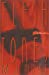

In [20]:
# imaeg 그리기
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'}

url = df['Image-URL-S'][0]
request_site = Request(url, headers=headers)
webpage = urlopen(request_site).read()
Image(webpage)

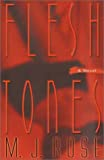

In [21]:
# imaeg 그리기
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'}

url = df['Image-URL-M'][0]
request_site = Request(url, headers=headers)
webpage = urlopen(request_site).read()
Image(webpage)

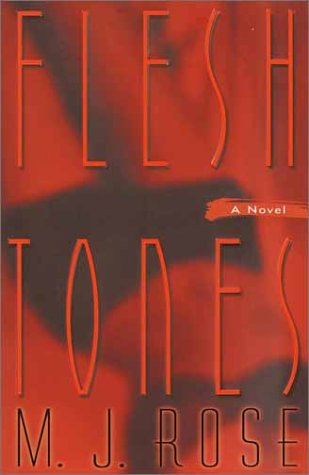

In [22]:
# imaeg 그리기
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'}

url = df['Image-URL-L'][0]
request_site = Request(url, headers=headers)
webpage = urlopen(request_site).read()
Image(webpage)

In [23]:
# Book-Rating
np.sort(df['Book-Rating'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

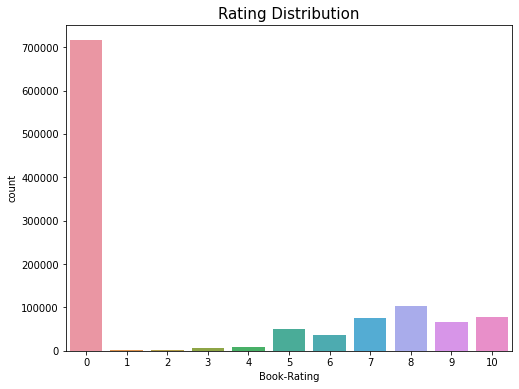

In [24]:
plt.figure(figsize=(8,6))
sns.countplot(x='Book-Rating',data=df)
plt.title('Rating Distribution', size=15)
plt.show()

In [25]:
df['Book-Rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

### 1-4. 데이터 전처리

- User-id
  - object형으로 변환
- location
  - 나라, 도시, 주로 구분지어 새로운 컬럼 생성
  - n/a 값으로 채워진 값들이 존재함
- Age
  - 결측치 존재
  - 이상치 있음(0세, 100세 이상) -> 처리 고민
  - float -> int형 변환
-  Book-Title, Book-Author
  - 결측치 존재 -> 다른 컬럼을 확인해서 채울 수 있는 값인지 확인 필요
- Publisher
  - 결측치 존재 -> Book-Title을 확인해서 채울 수 있는 값인지 확인 필요(같은 책이어도 서로 다른 출판사인 경우도 존재하긴하던데...)
- Year-Of-Publication
  - 이상치 존재(0, 2050 등) -> 처리 필요
  - 1300년대 출판이 진짜인지 오류인지 확인 필요
  - float -> object형 변환필요
- image 컬럼 삭제
- ratings 값이 0(즉, 점수를 주지 않은 값)이 너무 많음

In [26]:
df.columns

Index(['User-ID', 'Location', 'Age', 'ISBN', 'Book-Rating', 'Book-Title',
       'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S',
       'Image-URL-M', 'Image-URL-L'],
      dtype='object')

#### feature engineering

In [27]:
# feature engineering
location = df['Location'].str.split(', ', n=2, expand=True)
location.columns=['city', 'state', 'country']

df.loc[:, 'city'] = location['city']
df.loc[:, 'state'] = location['state']
df.loc[:, 'country'] = location['country']

#### 컬럼 삭제

In [28]:
# 컬럼 삭제
drop_col = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Location']
df.drop(drop_col, axis=1, inplace=True)

#### year

In [29]:
np.sort(df['Year-Of-Publication'].unique())

array([   0., 1376., 1378., 1806., 1897., 1900., 1901., 1902., 1904.,
       1906., 1908., 1909., 1910., 1911., 1914., 1917., 1919., 1920.,
       1921., 1922., 1923., 1924., 1925., 1926., 1927., 1928., 1929.,
       1930., 1931., 1932., 1933., 1934., 1935., 1936., 1937., 1938.,
       1939., 1940., 1941., 1942., 1943., 1944., 1945., 1946., 1947.,
       1948., 1949., 1950., 1951., 1952., 1953., 1954., 1955., 1956.,
       1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964., 1965.,
       1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973., 1974.,
       1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982., 1983.,
       1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992.,
       1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2008., 2010., 2011., 2012.,
       2020., 2021., 2024., 2026., 2030., 2037., 2038., 2050.,   nan])

In [30]:
df['Year-Of-Publication'].value_counts()

2002.0    91801
2001.0    79803
1999.0    75195
2003.0    72539
2000.0    72334
          ...  
2008.0        1
2012.0        1
2024.0        1
1378.0        1
1910.0        1
Name: Year-Of-Publication, Length: 116, dtype: int64

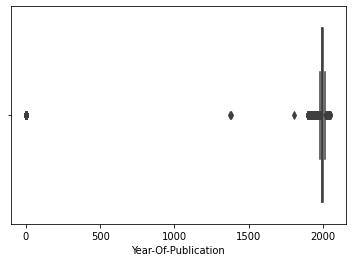

In [31]:
sns.boxplot(df['Year-Of-Publication'])

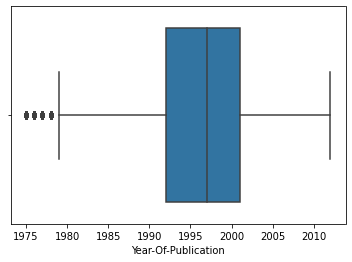

In [32]:
temp = df.loc[(df['Year-Of-Publication'] >= 1975) & (df['Year-Of-Publication'] < 2013), 'Year-Of-Publication']
sns.boxplot(temp)

In [33]:
# drop_year(범위 1975 ~ 2012년까지)
drop_year = df[(df['Year-Of-Publication'] < 1975) | (df['Year-Of-Publication'] > 2012)].index
df = df.drop(drop_year).reset_index(drop=True)
df.shape

(1120247, 11)

#### age

In [34]:
df['Age'].describe()

count    818324.000000
mean         37.269069
std          14.243514
min           0.000000
25%          28.000000
50%          35.000000
75%          45.000000
max         244.000000
Name: Age, dtype: float64

In [35]:
df['Age'].value_counts()

33.0     35261
29.0     34513
36.0     29457
30.0     29292
32.0     28900
         ...  
98.0         1
123.0        1
156.0        1
95.0         1
147.0        1
Name: Age, Length: 142, dtype: int64

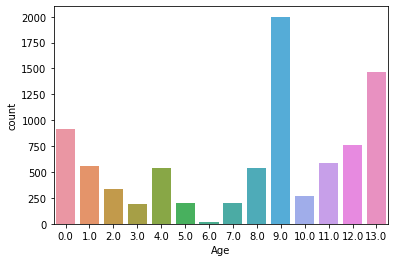

In [36]:
sns.countplot(df.loc[df['Age'] < 14, 'Age'])

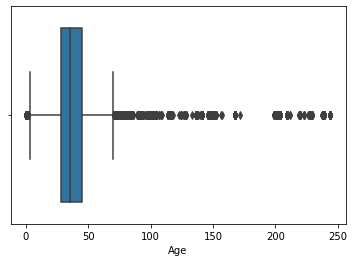

In [37]:
# age 컬럼
sns.boxplot(df['Age'])

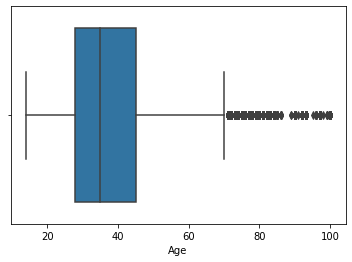

In [38]:
temp = df[(df['Age'] <= 100) & (df['Age'] >= 14)]
sns.boxplot(temp['Age'])

In [39]:
drop_age = df[(df['Age'] > 100) | (df['Age'] < 14)].index
df = df.drop(drop_age).reset_index(drop=True)
df.shape

(1108342, 11)

#### 타입 변환

In [40]:
df['Year-Of-Publication'] = df['Year-Of-Publication'].astype("O")

In [41]:
df['User-ID'] = df['User-ID'].astype('O')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108342 entries, 0 to 1108341
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1108342 non-null  object 
 1   Age                  806419 non-null   float64
 2   ISBN                 1108342 non-null  object 
 3   Book-Rating          1108342 non-null  int64  
 4   Book-Title           991817 non-null   object 
 5   Book-Author          991816 non-null   object 
 6   Year-Of-Publication  991817 non-null   object 
 7   Publisher            991815 non-null   object 
 8   city                 1108342 non-null  object 
 9   state                1108342 non-null  object 
 10  country              1081526 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 93.0+ MB


#### 중복값 존재 여부

In [43]:
df.duplicated(['User-ID', 'ISBN']).sum()

0

#### dataset 분리

In [44]:
df['User-ID'].value_counts()

11676     13196
198711     7295
153662     6051
98391      5891
35859      5779
          ...  
116518        1
116515        1
116512        1
116511        1
276721        1
Name: User-ID, Length: 102430, dtype: int64

In [45]:
# user-id 중 최빈값인 user-id의 데이터셋만 불러오기
temp_df = df[df['User-ID'] == 11676]

temp_df.shape

(13196, 11)

In [46]:
# book-rating이 1~10인 값만
del_idx = temp_df[temp_df['Book-Rating'] == 0].index
temp_df = temp_df.drop(del_idx).reset_index(drop=True)

temp_df.shape

(8259, 11)

In [47]:
# drop_col
drop_col = ['User-ID', 'city', 'state', 'country', 'Age', 'ISBN']
temp_df.drop(drop_col, axis=1, inplace=True)

In [48]:
target = 'Book-Rating'
X = temp_df.drop(target, axis=1)
y = temp_df[target]

X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=temp_df['Book-Rating'])
X_train, X_val, y_train,  y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((5285, 4), (1652, 4))

## 2. 학습진행

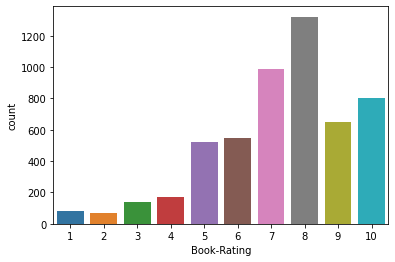

In [49]:
sns.countplot(y_train)

In [50]:
y_train.value_counts().sort_values()

2       71
1       79
3      136
4      173
5      521
6      546
9      648
10     801
7      988
8     1322
Name: Book-Rating, dtype: int64

In [51]:
def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    auc = roc_auc_score(y_test, pred_proba_po, multi_class='ovr')
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

In [52]:
def plot_confusion_matrix(model, X_val_encoded, y_val):
    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()

### baseline

In [53]:
baseline = [y_train.mode()[0]] * len(y_train)
print(classification_report(y_train, baseline))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        79
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00       136
           4       0.00      0.00      0.00       173
           5       0.00      0.00      0.00       521
           6       0.00      0.00      0.00       546
           7       0.00      0.00      0.00       988
           8       0.25      1.00      0.40      1322
           9       0.00      0.00      0.00       648
          10       0.00      0.00      0.00       801

    accuracy                           0.25      5285
   macro avg       0.03      0.10      0.04      5285
weighted avg       0.06      0.25      0.10      5285



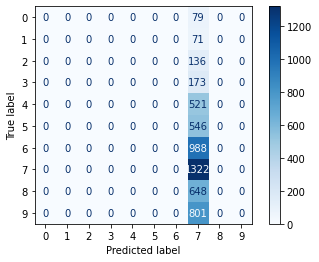

In [54]:
cm = confusion_matrix(y_train, baseline)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.show()

### DecisionTreeClassifier

In [271]:
# 파이프라인 설정
dt_pipe = imbpipeline(steps = [['imputer', SimpleImputer(strategy='most_frequent')],
                               ['encoder', OrdinalEncoder()],
                              #  ['smote', SMOTE(random_state=42)],
                               ['decisiontreeclassifier',  DecisionTreeClassifier(random_state=42, criterion="gini",)]])

In [272]:
# 하이퍼파라미터 범위 지정
params = {
  "decisiontreeclassifier__max_depth": [2, 4, 6],
  "decisiontreeclassifier__min_samples_split": [2, 4, 6]
}

# randomized search 진행
randomized_search = RandomizedSearchCV(
  dt_pipe,
  param_distributions=params,
  n_iter=10,
  cv=3,
  verbose=5,
  random_state=42,
  scoring='roc_auc_ovr_weighted'
)

randomized_search.fit(X_train, y_train);

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=2;, score=0.500 total time=   0.6s
[CV 2/3] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=2;, score=0.500 total time=   0.3s
[CV 3/3] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=2;, score=0.501 total time=   0.2s
[CV 1/3] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=4;, score=0.500 total time=   0.3s
[CV 2/3] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=4;, score=0.500 total time=   0.3s
[CV 3/3] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=4;, score=0.501 total time=   0.3s
[CV 1/3] END decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=6;, score=0.500 total time=   0.3s
[CV 2/3] END decisiontreeclassifier__max_depth=2, d

In [273]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 AUC: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'decisiontreeclassifier__min_samples_split': 4, 'decisiontreeclassifier__max_depth': 6}
최적 AUC:  0.5027685561325352


In [274]:
# 최적의 하이퍼파라미터 모델 선택
dt_model = randomized_search.best_estimator_

In [275]:
# print(classification_report(y_train, dt_model.predict(X_train)))

In [321]:
print("학습데이터 AUC: ")
print(randomized_search.best_score_)
print()
print("검증데이터 평가지표: ")
get_clf_eval(y_val, pred= dt_model.predict(X_val), pred_proba_po=dt_model.predict_proba(X_val))

학습데이터 AUC: 
0.50801166241158

검증데이터 평가지표: 
정확도: 0.2186, 정밀도: 0.1382, 재현율: 0.2186, F1: 0.1319, AUC: 0.4980


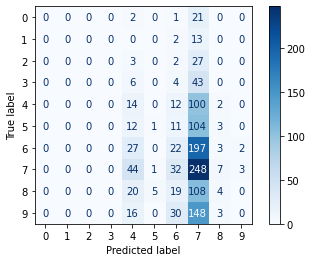

In [277]:
plot_confusion_matrix(dt_model, X_val, y_val)

### RandomForestClassifier

In [55]:
# 파이프라인 설정
rf_pipe = imbpipeline(steps = [['imputer', SimpleImputer(strategy='most_frequent')],
                               ['encoder', OrdinalEncoder()],
                               ['smote', RandomUnderSampler(random_state=42)],
                               ['randomforestclassifier',  RandomForestClassifier(random_state=42,)]])

In [56]:
# 하이퍼파라미터 범위 지정
params = {
  "randomforestclassifier__max_depth": [2, 4, 6],
}

# randomized search 진행
randomized_search = RandomizedSearchCV(
  rf_pipe,
  param_distributions=params,
  n_iter=10,
  cv=5,
  verbose=3,
  random_state=42,
  scoring='roc_auc_ovr_weighted'
)
randomized_search.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END randomforestclassifier__max_depth=2;, score=0.507 total time=   0.5s
[CV 2/5] END randomforestclassifier__max_depth=2;, score=0.518 total time=   0.4s
[CV 3/5] END randomforestclassifier__max_depth=2;, score=0.494 total time=   0.4s
[CV 4/5] END randomforestclassifier__max_depth=2;, score=0.500 total time=   0.4s
[CV 5/5] END randomforestclassifier__max_depth=2;, score=0.482 total time=   0.4s
[CV 1/5] END randomforestclassifier__max_depth=4;, score=0.516 total time=   0.4s
[CV 2/5] END randomforestclassifier__max_depth=4;, score=0.514 total time=   0.5s
[CV 3/5] END randomforestclassifier__max_depth=4;, score=0.508 total time=   0.3s
[CV 4/5] END randomforestclassifier__max_depth=4;, score=0.500 total time=   0.3s
[CV 5/5] END randomforestclassifier__max_depth=4;, score=0.473 total time=   0.3s
[CV 1/5] END randomforestclassifier__max_depth=6;, score=0.516 total time=   0.3s
[CV 2/5] END randomforestclassifier__m

In [57]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 AUC: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 6}
최적 AUC:  0.5049233109534969


In [58]:
# 최적의 하이퍼파라미터 모델 선택
rf_model = randomized_search.best_estimator_

In [59]:
# print(classification_report(y_train, rf_model.predict(X_train)))

In [60]:
print("학습데이터 AUC: ")
print(randomized_search.best_score_)
print()
print("검증데이터 평가지표: ")
get_clf_eval(y_val, pred= rf_model.predict(X_val), pred_proba_po=rf_model.predict_proba(X_val))

학습데이터 AUC: 
0.5049233109534969

검증데이터 평가지표: 
정확도: 0.1747, 정밀도: 0.1826, 재현율: 0.1747, F1: 0.1579, AUC: 0.5225


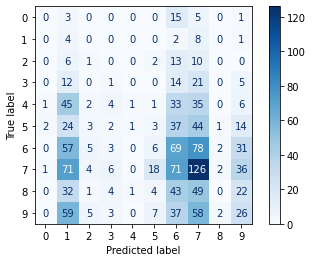

In [61]:
plot_confusion_matrix(rf_model, X_val, y_val)

### ExtraTreeClassifier



In [251]:
from sklearn.ensemble import ExtraTreesClassifier

# 파이프라인 설정
et_pipe = imbpipeline(steps = [['imputer', SimpleImputer(strategy='most_frequent')],
                               ['encoder', OrdinalEncoder()],
                               ['smote', RandomUnderSampler(random_state=42)],
                               ['extratreesclassifier',  ExtraTreesClassifier(random_state=42)]])

# 하이퍼파라미터 범위 지정
params = {
  "extratreesclassifier__max_depth": [2, 4, 6],
  "extratreesclassifier__n_estimators": [2, 4, 6],
  "extratreesclassifier__max_leaf_nodes": [2, 4, 6]
}

# randomized search 진행
randomized_search = RandomizedSearchCV(
  et_pipe,
  param_distributions=params,
  n_iter=10,
  cv=5,
  verbose=3,
  random_state=42,
  scoring='roc_auc_ovr_weighted'
)
randomized_search.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END extratreesclassifier__max_depth=2, extratreesclassifier__max_leaf_nodes=6, extratreesclassifier__n_estimators=6;, score=0.499 total time=   0.2s
[CV 2/5] END extratreesclassifier__max_depth=2, extratreesclassifier__max_leaf_nodes=6, extratreesclassifier__n_estimators=6;, score=0.503 total time=   0.2s
[CV 3/5] END extratreesclassifier__max_depth=2, extratreesclassifier__max_leaf_nodes=6, extratreesclassifier__n_estimators=6;, score=0.515 total time=   0.2s
[CV 4/5] END extratreesclassifier__max_depth=2, extratreesclassifier__max_leaf_nodes=6, extratreesclassifier__n_estimators=6;, score=0.506 total time=   0.2s
[CV 5/5] END extratreesclassifier__max_depth=2, extratreesclassifier__max_leaf_nodes=6, extratreesclassifier__n_estimators=6;, score=0.498 total time=   0.2s
[CV 1/5] END extratreesclassifier__max_depth=4, extratreesclassifier__max_leaf_nodes=4, extratreesclassifier__n_estimators=4;, score=0.496 total time

In [252]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 AUC: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'extratreesclassifier__n_estimators': 2, 'extratreesclassifier__max_leaf_nodes': 4, 'extratreesclassifier__max_depth': 6}
최적 AUC:  0.5048444010146783


In [253]:
# 최적의 하이퍼파라미터 모델 선택
et_model = randomized_search.best_estimator_

In [254]:
# print(classification_report(y_val, et_model.predict(X_val)))

In [323]:
print("학습데이터 AUC: ")
print(randomized_search.best_score_)
print()
print("검증데이터 평가지표: ")
get_clf_eval(y_val, pred= et_model.predict(X_val), pred_proba_po=et_model.predict_proba(X_val))

학습데이터 AUC: 
0.50801166241158

검증데이터 평가지표: 
정확도: 0.1800, 정밀도: 0.0910, 재현율: 0.1800, F1: 0.0986, AUC: 0.5136


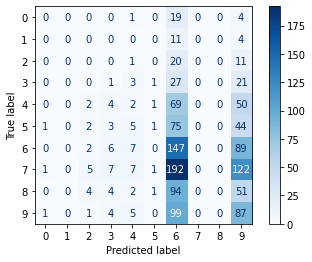

In [256]:
plot_confusion_matrix(et_model, X_val, y_val)

### XGBClassifier

In [363]:
# 파이프라인 설정
xgb_pipe = imbpipeline(steps = [['imputer', SimpleImputer(strategy='most_frequent')],
                                ['encoder', OrdinalEncoder()],
                              #  ['smote', SMOTEENN(random_state=42)],
                               ['xgbclassifier',  XGBClassifier(objective="multi:softmax", num_class=10, random_state=42, n_jobs=-1, scale_pos_weight='balanced')]]) # scale_pos_weight='balanced'

In [364]:
# # 파이프라인 설정
# xgb_pipe = make_pipeline(
#     OrdinalEncoder(),
#     XGBClassifier(objective="multi:softmax", num_class=10, random_state=42, n_jobs=-1,  scale_pos_weight='balanced')
#     )

In [365]:
# 하이퍼파라미터 범위 지정
params = {
  "xgbclassifier__max_depth": [1, 2, 3],
  "xgbclassifier__max_leaf_node": [2, 4, 6],
}

# randomized search 진행
randomized_search = RandomizedSearchCV(
  xgb_pipe,
  param_distributions=params,
  n_iter=5,
  cv=3,
  verbose=3,
  random_state=42,
  scoring='roc_auc_ovr_weighted'
)
randomized_search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END xgbclassifier__max_depth=3, xgbclassifier__max_leaf_node=4;, score=0.496 total time=   1.7s
[CV 2/3] END xgbclassifier__max_depth=3, xgbclassifier__max_leaf_node=4;, score=0.508 total time=   1.7s
[CV 3/3] END xgbclassifier__max_depth=3, xgbclassifier__max_leaf_node=4;, score=0.507 total time=   1.7s
[CV 1/3] END xgbclassifier__max_depth=1, xgbclassifier__max_leaf_node=4;, score=0.501 total time=   0.8s
[CV 2/3] END xgbclassifier__max_depth=1, xgbclassifier__max_leaf_node=4;, score=0.513 total time=   0.9s
[CV 3/3] END xgbclassifier__max_depth=1, xgbclassifier__max_leaf_node=4;, score=0.498 total time=   3.4s
[CV 1/3] END xgbclassifier__max_depth=2, xgbclassifier__max_leaf_node=6;, score=0.506 total time=   1.2s
[CV 2/3] END xgbclassifier__max_depth=2, xgbclassifier__max_leaf_node=6;, score=0.517 total time=   1.2s
[CV 3/3] END xgbclassifier__max_depth=2, xgbclassifier__max_leaf_node=6;, score=0.505 total time=   

In [366]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 AUC: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__max_leaf_node': 6, 'xgbclassifier__max_depth': 2}
최적 AUC:  0.5094540357093563


In [367]:
# 최적의 하이퍼파라미터 모델 선택
xgb_model = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(objective="multi:softmax", num_class=10, random_state=42, n_jobs=-1,  scale_pos_weight='balanced', max_depth=randomized_search.best_params_['xgbclassifier__max_depth'], max_leaf_node=randomized_search.best_params_['xgbclassifier__max_leaf_node'])
    )

xgb_model.fit(X_train, y_train);

In [368]:
# print(classification_report(y_train, xgb_model.predict(X_train)))

In [369]:
print("학습데이터 AUC: ")
print(randomized_search.best_score_)
print()
print("검증데이터 평가지표: ")
get_clf_eval(y_val, pred= xgb_model.predict(X_val), pred_proba_po=et_model.predict_proba(X_val))

학습데이터 AUC: 
0.5094540357093563

검증데이터 평가지표: 
정확도: 0.1952, 정밀도: 0.1113, 재현율: 0.1952, F1: 0.1242, AUC: 0.5136


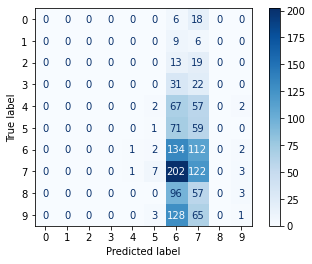

In [370]:
plot_confusion_matrix(xgb_model, X_val, y_val)

## 3. 모델 해석

In [64]:
model = rf_model

In [444]:
score = model.score(X_test, y_test)
pi = pd.Series(dtype=float)

n_iter = 10  # 랜덤으로 특성을 섞어 평가 성능을 확인하는 과정을 몇 번 반복할지 결정합니다.
np.random.seed(2) # random seed를 고정하여 반복적으로 아래 코드를 수행해도 같은 결과가 나오게 합니다.

for feature in X_test.columns:
    X_test_permed = X_test.copy()

    # 모델을 재학습하지 않고, 기존 모델에서 feature 값을 여러 번(n_iter) 섞고 검증하여 평균 성능을 확인합니다.
    scores_permutated = []
    for _ in range(n_iter):
        X_test_permed[feature] = np.random.permutation(X_test_permed[feature])
        scores_permutated.append(model.score(X_test_permed, y_test))
    avg_score_permutated = np.mean(scores_permutated)
    print(f"Perm {feature} :: 검증 정확도 {avg_score_permutated:.6f}")

    # permutation importance는 해당 특성을 랜덤으로 섞었을 때의 성능 하락폭으로 정의됩니다.
    pi[feature] = score - avg_score_permutated

Perm Book-Title :: 검증 정확도 0.161259
Perm Book-Author :: 검증 정확도 0.153935
Perm Year-Of-Publication :: 검증 정확도 0.149879
Perm Publisher :: 검증 정확도 0.152482


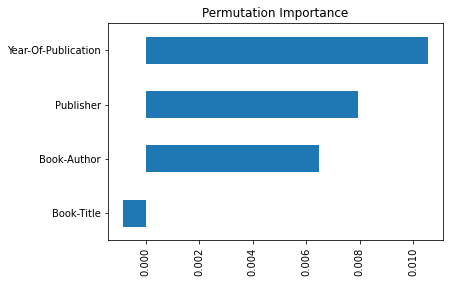

In [445]:
pi.sort_values().plot.barh()
plt.title("Permutation Importance")
plt.xticks(rotation=90)
plt.show()

In [65]:
# 테스트 데이터 셋
print("테스트데이터 평가지표: ")
get_clf_eval(y_test, pred= model.predict(X_test), pred_proba_po=model.predict_proba(X_test))

테스트데이터 평가지표: 
정확도: 0.1604, 정밀도: 0.1496, 재현율: 0.1604, F1: 0.1459, AUC: 0.4978


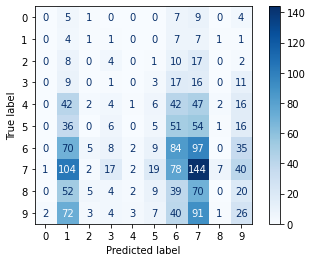

In [66]:
plot_confusion_matrix(model, X_test, y_test)

### 문제점
- 새로운 데이터에서 category(장르)와 관련된 부분만을 가지고 합치고 싶음
- model-based algorithm을 활용하기 위한 데이터셋 만들고 싶음.
  - 인공지능 기반 추천 시스템(https://blog.insilicogen.com/61)
    - 내용 기반 추천 시스템
    - 협업 필터링
      - memory-based algorithm: 사용자 간 또는 콘텐츠 간 유사도 계산 결과를 기반으로 예측
      - model-based algorithm: 사용자와 아이템 간의 평점 행렬 속에 숨어 있는 잠재 요인 행렬을 추출하여 내적 곱을 통해 사용자가 평가하지 않은 항목들에 대한 평점까지 예측


## 참고
- https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/
- https://romg2.github.io/mlguide/03_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-04.-%EB%B6%84%EB%A5%98-XGBoost/
- https://dining-developer.tistory.com/27
- https://aimb.tistory.com/152
- https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
- [extratreesclassifier](https://tensorflow.blog/2017/11/30/%EB%8D%94%EC%9A%B1-%EB%9E%9C%EB%8D%A4%ED%95%9C-%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8-%EC%9D%B5%EC%8A%A4%ED%8A%B8%EB%A6%BC-%EB%9E%9C%EB%8D%A4-%ED%8A%B8%EB%A6%ACextratreesclassifier/)